In [1]:
!pip list | grep gensim
!pip install --upgrade gensim
!pip install nltk
!pip install spacy
!pip install gensim
!pip install pyLDAvis
!pip install --upgrade sklearn

gensim                   3.6.0          
     |████████████████████████████████| 24.2MB 148kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.6MB 2.6MB/s 
     |████████████████████████████████| 552kB 17.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=512b40461319d711d48ea0c8a399c2fa71a4d41f2cd4a5870def573aa01d0290
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=6cddfbc10dc52ce200a8c4b703f47d5a5d9c53681b75bfe5c5b28341fd063de9
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
root_path = '/content/drive/My Drive/[JOB] RA'

In [4]:
root_path = '/content/drive/My Drive/[JOB] RA'
def shellquote(s):
    return "'" + s.replace("'", "'\\''") + "'"
cur_path = shellquote(root_path)

In [5]:
!ls {cur_path}

 abstracts.pkl
 Assignment_topic_modelling_20200710_300data.ipynb
'BCCDC digital public health.gdoc'
'[BCCDC]: List of metadata.gdoc'
 data
'data (1)'
'Digital Public Health Narrative Review Protocol 2020 05 19.docx'
'Digital Public Health Narrative Review Protocol 2020 05 19.gdoc'
 digital_public_health_v2.ipynb
 download_data.ipynb
 hiring
 lda_gensim_10.model
 lda_gensim_10.model.expElogbeta.npy
 lda_gensim_10.model.id2word
 lda_gensim_10.model.state
 lda_gensim_20.model
 lda_gensim_20.model.expElogbeta.npy
 lda_gensim_20.model.id2word
 lda_gensim_20.model.state
 lda.model
 lda.model.expElogbeta.npy
 lda.model.id2word
 lda.model.state
 mallet-2.0.8.tar.gz
'MEDLINE Results 2 (1).xlsx'
'MEDLINE Results 2.gsheet'
'MEDLINE Results 2.xlsx'
 model
 parsing_data_20200601.ipynb
 parsing_xml_20200604.ipynb
 pmc_list.txt
 pub_dates.pkl
 sample_300
 search_term_1.csv.gsheet
 topic_distribution_20200714.gsheet
 topic_probs.pkl
 UKBiobank_Data_Loader_V4.ipynb
 Untitled
 valid_pmc_list10.txt
 val

# Assignment

0: co-location of data, build LDA/NMF
- another thought: https://medium.com/@manjunathhiremath.mh/identifying-bigrams-trigrams-and-four-grams-using-word2vec-dea346130eb

1: how to pick the optimal # of topics

2: doc-topic distribution, hot topic by year 



## Loading libraries and data

In [6]:
import pandas as pd
import numpy as np
import os
import sklearn
import sys
np.set_printoptions(threshold=sys.maxsize)
from sklearn.model_selection import train_test_split
import re
from pprint import pprint
from glob import glob
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pathlib import Path
import glob
from bs4 import BeautifulSoup
import operator
import pickle as pkl

In [7]:
path = root_path + "/sample_300/"
print(path)

/content/drive/My Drive/[JOB] RA/sample_300/


In [8]:
def get_abstract(soup):
    if soup.find("abstract") is None:
        return "NaN"
    
    return soup.find('abstract').text

def get_pub_date(soup):
  pub_d = soup.find('pub-date')
  return pub_d.find('year').text


In [9]:

def get_sample_data(path):
    pathlist = Path(path).glob('**/*.xml')
    # import pdb; pdb.set_trace()

    abstracts = []
    pub_dates = []
    for path in pathlist:
        # because path is object not string
        path_in_str = str(path)
        # name_str = path_in_str.split('/')[-1]
        soup = BeautifulSoup(open(path_in_str, 'r'))
        #pub_d = soup.find('pub-date')
        #pub_dates.append(int(pub_d.find('year').text))
        pub_dates.append(int(get_pub_date(soup)))
        abstracts.append(get_abstract(soup))
        # todo: get full articles?
    
    ds = pd.Series(data=pub_dates)

    return np.array(abstracts), ds


In [10]:
X, pub_dates = get_sample_data(path)
X.shape

(378,)

In [11]:
X[1]

'\n\nBackground\nBreast cancer, the most common tumor in women in Mali and worldwide has been linked to several risk factors, including genetic factors, such as the PIN3 16-bp duplication polymorphism of TP53. The aim of our study was to evaluate the role of the PIN3 16-bp duplication polymorphism in the susceptibility to breast cancer in the Malian population and to perform a meta-analysis to better understand the correlation with data from other populations.\n\n\nMethods\nWe analyzed the PIN3 16-bp duplication polymorphism in blood samples of 60 Malian women with breast cancer and 60 healthy Malian women using PCR. In addition, we performed a meta-analysis of case-control study data from international databases, including Pubmed, Harvard University Library, Genetics Medical Literature Database, Genesis Library and Web of Science. Overall, odds ratio (OR) with 95% CI from fixed and random effects models were determined. Inconsistency was used to assess heterogeneity between studies an

In [ ]:
type(X)

numpy.ndarray

# Assignment0: co-location and build model


In [13]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
# data cleaning 

# Remove Emails
# data = [re.sub('\S*@\S*\s?', '', sent) for each in data]

# Remove new line characters
data = [re.sub('\s+', ' ', each) for each in X]

# # Remove distracting single quotes
# data = [re.sub("\'", "", sent) for each in data]

## Using Sklearn

Preprocessing include:

- tokenization
  - remove stop words

Tokenize the words

In [ ]:
data

In [ ]:
data_lemmatized

In [20]:
# transform data_lematized to data format !!!!!
res_data = []
for doc in data_lemmatized:
  each_doc = ""
  for word in doc:
    each_doc = " ".join(doc)
  res_data.append(each_doc)
print(res_data)
print(len(res_data))

['graphical compute video surveillance mobile computing microorganism patient monitor wireless sensor network', 'background common tumor woman mali worldwide link several risk factor include genetic factor duplication study evaluate role pin duplication susceptibility malian population perform correlation datum population method analyze pin duplication polymorphism blood sample malian woman healthy malian woman use addition perform case study international database include library genetic literature database genesis library web science overall fix random_effect model determine inconsistency use assess heterogeneity study publication bias estimate use funnel plot result study malian patient duplication risk observe dominant model recessive model article include total disease case control dominant model increase risk detect recessive model study show duplication polymorphism significant risk factor breast_cancer malian woman finding support datum carry different ethnic group world', 'hig

In [21]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')
df = cv.fit_transform(res_data)


Apply LDA

In [22]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model1 = LatentDirichletAllocation(n_components = 20, random_state = 42) # n_components = topics
lda_model1.fit(df)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
# def get_lda_topics(model, num_topics):
#     word_dict = {};
#     for i in range(num_topics):
#         words = model.show_topic(i, topn = 20)
#         word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
#     return pd.DataFrame(word_dict)

# get_lda_topics(lda_model1, 15)

In [ ]:
for index, topic in enumerate(lda_model1.components_):
    print(f'Top 20 words for Topic #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
    #print(cv.get_feature_names()[0])
    print('\n')
  
# def get_lda_topics():
#     word_dict = {}
#     for i, topic in enumerate(lda_model1.components_):
#         #words = model.show_topic(i, topn = 20)
#         words = cv.get_feature_names()[i] 
#         word_dict['Topic #' + '{:02d}'.format(i)] = [topic for topic in topic]
#         #print(words)
#     return pd.DataFrame(word_dict)

# # Print the Keyword in the 20 topics
# get_lda_topics()

In [58]:
# for i in pub_dates[pub_dates==2019].index:
#   # list of topic-probability given a doc
#   sample_df = res_data[1]
#   res = lda_model1.transform(sample_df)
#   topic_ps = res
#   topic_prob_for_year.append([p for t,p in topic_ps])


[Int64Index([105, 198, 278, 313, 335], dtype='int64')]

In [106]:
#  mytext_4 = cv.transform([res_data[105]])
#  topic_probability_scores = lda_model1.transform(mytext_4)
#  topic_probability_scores

array([[4.54545476e-04, 4.54545458e-04, 4.54545461e-04, 9.91363636e-01,
        4.54545464e-04, 4.54545460e-04, 4.54545463e-04, 4.54545461e-04,
        4.54545456e-04, 4.54545461e-04, 4.54545461e-04, 4.54545458e-04,
        4.54545462e-04, 4.54545462e-04, 4.54545459e-04, 4.54545461e-04,
        4.54545460e-04, 4.54545460e-04, 4.54545458e-04, 4.54545460e-04]])

<204x2589 sparse matrix of type '<class 'numpy.int64'>'
	with 188 stored elements in Compressed Sparse Row format>

In [40]:
# get the year data, make it in df form 
# res = model.transform(year_df)
# res[i] will have list of probability 
k = 20
results = {}
print(pub_dates.unique())
for year in pub_dates.unique():
  topic_prob_for_year = []
  for i in pub_dates[pub_dates==year].index:
  
    # vectorize transform 
    #print(res_data[i].split())
    mytext_4 = cv.transform([res_data[i]])
    #print(mytext_4)

    # LDA transform
    topic_probability_scores = lda_model1.transform(mytext_4)
  
    topic_prob_for_year.append(topic_probability_scores)
  # import pdb; pdb.set_trace()
  topic_prob_for_year=np.mean(np.array(topic_prob_for_year).squeeze(),axis=0)
  #print(f"before sort: {topic_probability_scores}")
  topk = topic_prob_for_year.argsort()[-k:][::-1]
  #print(f"after sort: {topic_probability_scores}")
  # print(year, topk, np.sort(topic_prob_for_year)[::-1], topic_prob_for_year[topk])
  print(year, topk, topic_prob_for_year)

  # save to a dict
  results[year] = topic_prob_for_year
results

[2020 2019]
2020 [ 0 13 12  3  2 14  9 19  6  4  7 11 16 10 18  1 15  8  5 17] [0.11412901 0.03090981 0.05906047 0.07770455 0.04070333 0.02149625
 0.04083416 0.03803327 0.02263745 0.05649455 0.03426691 0.03705175
 0.09697757 0.1125892  0.05872417 0.02611542 0.0351822  0.01729817
 0.03101754 0.04877422]
2019 [ 9  3 13  2 15 12  0  7 14 10 19  6 11  4 18 16  1  5  8 17] [0.0004834  0.0004834  0.06236347 0.36626783 0.0004834  0.0004834
 0.0004834  0.0004834  0.0004834  0.39615794 0.0004834  0.0004834
 0.03111088 0.09979215 0.0004834  0.03754019 0.0004834  0.0004834
 0.0004834  0.0004834 ]


{2019: array([0.0004834 , 0.0004834 , 0.06236347, 0.36626783, 0.0004834 ,
        0.0004834 , 0.0004834 , 0.0004834 , 0.0004834 , 0.39615794,
        0.0004834 , 0.0004834 , 0.03111088, 0.09979215, 0.0004834 ,
        0.03754019, 0.0004834 , 0.0004834 , 0.0004834 , 0.0004834 ]),
 2020: array([0.11412901, 0.03090981, 0.05906047, 0.07770455, 0.04070333,
        0.02149625, 0.04083416, 0.03803327, 0.02263745, 0.05649455,
        0.03426691, 0.03705175, 0.09697757, 0.1125892 , 0.05872417,
        0.02611542, 0.0351822 , 0.01729817, 0.03101754, 0.04877422])}

In [ ]:
# topic porbability for each documnet 
sample_doc_topic = 
for n in range(sample_doc_topic.shape[0]):
    topic_most_pr = sample_doc_topic[n]
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

    #doc_topic_list = sorted(sample_doc_topic[n], reverse=True)
    #print("doc: {} topic: {}\n".format(n,doc_topic_list))

In [ ]:
k = 20
results = {}

for year in pub_dates.unique():
  print(f"year!!!!!!!!!!: {year}")
  topic_prob_for_year = []
  for i in pub_dates[pub_dates==year].index:

    # list of topic-probability given a doc
    topic_ps = lda_gensim_10.get_document_topics(corpus[i],minimum_probability=0)
    topic_prob_for_year.append([p for t,p in topic_ps])
  topic_prob_for_year = np.mean(np.array(topic_prob_for_year),axis=0)

  topk = topic_prob_for_year.argsort()[-k:][::-1]
  print(year, topk, topic_prob_for_year)
  
  # save to a dict
  results[year] = topic_prob_for_year

## Using Gensim

Preprocessing include:
- tokenization (remove punctuations, unecessary characters)
- remove stop words
- colocation: bigram -> trigram -> Quadgram data
- lemmatization


Tokenization: tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.     

In [15]:
def tokenize_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(tokenize_to_words(data))
#data_words
data_words[:1]

[['graphical',
  'abstract',
  'cloud',
  'computing',
  'patient',
  'diagnosis',
  'video',
  'surveillance',
  'mobile',
  'computing',
  'microorganisms',
  'patient',
  'monitoring',
  'wireless',
  'sensor',
  'networks']]

Creating quadgram model

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold, fewer phrases to form
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
quadgram= gensim.models.Phrases(trigram[bigram[data_words]], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
quad_mod = gensim.models.phrases.Phraser(quadgram)

# See example
print(bigram_mod[data_words[10]])
print(trigram_mod[bigram_mod[data_words[10]]])
print(quad_mod[trigram_mod[bigram_mod[data_words[10]]]])


['background', 'hepatitis', 'virus', 'hcv', 'is', 'growing', 'public', 'health', 'problem', 'with', 'large', 'disease', 'burden', 'worldwide', 'in', 'china', 'many', 'people', 'living', 'with', 'hcv', 'are', 'unaware', 'of', 'their', 'hepatitis', 'status', 'and', 'not', 'connected', 'to', 'care', 'and', 'treatment', 'crowdsourcing', 'is', 'technique', 'that', 'invites', 'the', 'public', 'to', 'create', 'health', 'promotion', 'materials', 'and', 'has_been', 'found', 'to', 'increase', 'hiv', 'testing', 'uptake', 'including', 'in', 'china', 'this', 'trial', 'aims', 'to', 'evaluate', 'crowdsourcing', 'as', 'strategy', 'to', 'improve', 'hcv', 'awareness', 'testing', 'and', 'linkage', 'to', 'care', 'in', 'china', 'methods', 'randomized_controlled', 'two', 'armed', 'trial', 'rct', 'is', 'being', 'conducted', 'in', 'shenzhen', 'with', 'participants', 'recruited', 'from', 'primary', 'care', 'sectors', 'of', 'the', 'university', 'of', 'hong', 'kong', 'shenzhen', 'hospital', 'eligible', 'particip

Remove Stopwords, Make quadgram and Lemmatize


In [17]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# !python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [18]:
# Define functions for stopwords, bigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def make_quadgrams(texts):
    return [quad_mod[trigram_mod[bigram_mod[doc]]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_quadgrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])
# len(data_lemmatized).  378


[['graphical', 'compute', 'video', 'surveillance', 'mobile', 'computing', 'microorganism', 'patient', 'monitor', 'wireless', 'sensor', 'network']]


Create the Dictionary and Corpus needed for Topic Modeling

two main inputs to the LDA topic model using GenSim library are the dictionary(id2word) and the corpus.

eg: for the single doc, produce: a mapping of (word_id, word_frequency), (0,1) 1st word in the doc appear once

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
print(corpus[1:2])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[[(7, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 5), (33, 1), (34, 1), (35, 1), (36, 3), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 3), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 5), (54, 1), (55, 5), (56, 1), (57, 1), (58, 2), (59, 2), (60, 1), (61, 2), (62, 2), (63, 1), (64, 1), (65, 2), (66, 1), (67, 4), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 5), (75, 1), (76, 1), (77, 1), (78, 1), (79, 3), (80, 1), (81, 4), (82, 1), (83, 1)]]


##### id-word mapping:

In [ ]:
id2word[4]

'mobile'

##### Item-frequency

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]] # cp as sentence, corpus as each doc -> all docs

[[('compute', 1),
  ('computing', 1),
  ('graphical', 1),
  ('microorganism', 1),
  ('mobile', 1),
  ('monitor', 1),
  ('network', 1),
  ('patient', 1),
  ('sensor', 1),
  ('surveillance', 1),
  ('video', 1),
  ('wireless', 1)]]

### Building the Topic Model

In [ ]:
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20)
        word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

# Print the Keyword in the 15 topics
get_lda_topics(lda_model2, 15)

Topic #01     Topic #02  ...     Topic #14    Topic #15
0            high        health  ...         death       health
1   questionnaire  intervention  ...          gene        datum
2        response        social  ...        cancer       public
3          survey     community  ...          cell          use
4           covid        relate  ...         cause       system
5            face        mental  ...   feasibility         base
6          online       support  ...     retention     analysis
7          infect      diabetes  ...      pathogen       method
8             low         study  ...        genome    framework
9        increase       concern  ...          site         tool
10         report      research  ...   recruitment     approach
11         infant        report  ...      neonatal       result
12           risk      physical  ...     molecular        paper
13       question        impact  ...     infodemic  information
14          group         focus  ...      function       policy
15       gambling       promote  ...          fact       review
16        related       emotion  ...         email      digital
17       pandemic   therapeutic  ...  polymorphism     identify
18         change        people  ...          iron        study
19           cart         tweet  ...          firm      feature

[20 rows x 15 columns]

Evaluation Metric: Compute Model Perplexity and Coherence Score


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model2, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.545191180069414

Coherence Score:  0.41662289542886016


Visualize the topics-keywords

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.210316  0.011906       1        1  23.743767
8      0.183231  0.079518       2        1  17.304630
11     0.191083 -0.080593       3        1  14.520657
14     0.158467 -0.088654       4        1   8.374680
7      0.048671  0.214408       5        1   7.516237
1      0.072648 -0.081337       6        1   5.011367
12    -0.053926  0.235906       7        1   4.574621
9     -0.001287 -0.095104       8        1   3.758303
2     -0.013639 -0.055909       9        1   2.742832
0     -0.091174  0.057249      10        1   2.588231
4     -0.079794 -0.003029      11        1   2.407750
6     -0.070060 -0.101639      12        1   2.354865
5     -0.163297 -0.018674      13        1   1.953591
13    -0.194801 -0.032928      14        1   1.885175
3     -0.196437 -0.041123      15        1   1.263296, topic_info=              Term        Freq       Total Category  logprob  loglift
7          patient  536.000000  536.000000  Default  30.0000  30.0000
137         health  561.000000  561.000000  Default  29.0000  29.0000
74           study  677.000000  677.000000  Default  28.0000  28.0000
117           care  283.000000  283.000000  Default  27.0000  27.0000
469   intervention  223.000000  223.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
222          score    4.335730   45.403290  Topic15  -4.9128   2.0228
2735    successful    2.871242   11.961073  Topic15  -5.3249   2.9445
3374       operate    2.721034    9.059278  Topic15  -5.3787   3.1687
295       possible    3.004054   36.612679  Topic15  -5.2797   1.8710
374          adult    2.652754   49.840816  Topic15  -5.4041   1.4382

[876 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2861     13  0.924839       abnormal
1143      6  0.964677  acceptability
744       2  0.250206         access
744       4  0.125103         access
744       5  0.250206         access
...     ...       ...            ...
317       3  0.045152           year
317       9  0.009030           year
317      11  0.018061           year
2566      4  0.949183            yet
3131     11  0.927738        youtube

[1682 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 9, 12, 15, 8, 2, 13, 10, 3, 1, 5, 7, 6, 14, 4])

# Assignment 1: how to find the optimal number of topics

-  cohenrence score based
    - LDA 
      - con: the topics are fixed for the whole corpus, and the number of topics is assumed
to be known

    - NMF ??

- Bayesian nonparametric topic model
    - HDP: https://datascience.stackexchange.com/questions/128/latent-dirichlet-allocation-vs-hierarchical-dirichlet-process
      - pro: As far as pros and cons, HDP has the advantage that the maximum number of topics can be unbounded and learned from the data rather than specified in advance. 

In [ ]:
def plot_graph_score(coherence_values):
  # Show graph
  limit=100; start=2; step=6;
  x = range(start, limit, step)
  plt.plot(x, coherence_values)
  plt.xlabel("Num Topics")
  plt.ylabel("Coherence score")
  plt.legend(("coherence_values"), loc='best')
  plt.show()

  # Print the coherence scores
  for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


### Using LDA

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


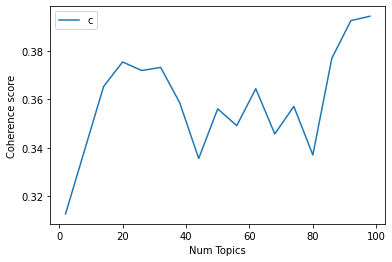

Num Topics = 2  has Coherence Value of 0.3126
Num Topics = 8  has Coherence Value of 0.3389
Num Topics = 14  has Coherence Value of 0.3654
Num Topics = 20  has Coherence Value of 0.3755
Num Topics = 26  has Coherence Value of 0.372
Num Topics = 32  has Coherence Value of 0.3733
Num Topics = 38  has Coherence Value of 0.3587
Num Topics = 44  has Coherence Value of 0.3356
Num Topics = 50  has Coherence Value of 0.3561
Num Topics = 56  has Coherence Value of 0.3491
Num Topics = 62  has Coherence Value of 0.3645
Num Topics = 68  has Coherence Value of 0.3457
Num Topics = 74  has Coherence Value of 0.3571
Num Topics = 80  has Coherence Value of 0.337
Num Topics = 86  has Coherence Value of 0.3771
Num Topics = 92  has Coherence Value of 0.3927
Num Topics = 98  has Coherence Value of 0.3945


In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=6)
plot_graph_score(coherence_values)
#plot_score(coherence_values)


In [ ]:
root_path

'/content/drive/My Drive/[JOB] RA'

In [ ]:
# Select the model and print the topics (Topics = 62)
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
## saving model to local
# import pickle
# file_path = f'{root_path}/lda.model'
# directory = os.path.dirname(file_path)
# if not os.path.exists(directory):
#   os.makedirs(directory)
# optimal_model.save(file_path)

optimal_model =  gensim.models.LdaModel.load(file_path)
optimal_model

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Using NMF

In [ ]:
def compute_coherence_values_nmf(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of NMF topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Nmf(
        corpus=corpus,
        num_topics=num_topics,
        id2word=id2word,
        chunksize=100,
        passes=10,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

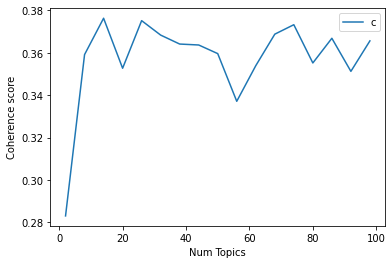

Num Topics = 2  has Coherence Value of 0.283
Num Topics = 8  has Coherence Value of 0.3592
Num Topics = 14  has Coherence Value of 0.3763
Num Topics = 20  has Coherence Value of 0.3527
Num Topics = 26  has Coherence Value of 0.3752
Num Topics = 32  has Coherence Value of 0.3684
Num Topics = 38  has Coherence Value of 0.3641
Num Topics = 44  has Coherence Value of 0.3637
Num Topics = 50  has Coherence Value of 0.3596
Num Topics = 56  has Coherence Value of 0.3371
Num Topics = 62  has Coherence Value of 0.3539
Num Topics = 68  has Coherence Value of 0.3688
Num Topics = 74  has Coherence Value of 0.3733
Num Topics = 80  has Coherence Value of 0.3552
Num Topics = 86  has Coherence Value of 0.3669
Num Topics = 92  has Coherence Value of 0.3513
Num Topics = 98  has Coherence Value of 0.3656


In [ ]:
# Can take a long time to run.
model_list_nmf, coherence_values_nmf = compute_coherence_values_nmf(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=6)
plot_graph_score(coherence_values_nmf)
#plot_score(coherence_values_nmf)

In [ ]:
# Select the model and print the topics 
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

### Using HDP


In [ ]:
# https://radimrehurek.com/gensim/models/hdpmodel.html
# Unlike its finite counterpart, latent Dirichlet allocation, the HDP topic model infers the number of topics from the data.
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel
hdp = HdpModel(corpus, id2word) 


In [ ]:
# Number of topics for which most probable num_words words will be fetched
topic_info = hdp.print_topics(num_topics=-1, num_words=10)
# topic_info = hdp.print_topics() # default by 20 topics
print(len(topic_info))
print(topic_info[0])
# HDP will calculate as many topics as the assigned truncation level. However, it may be the case that many of these topics have 
# basically zero probability of occurring.

150
(0, '0.005*study + 0.004*health + 0.003*patient + 0.003*use + 0.003*risk + 0.003*include + 0.002*result + 0.002*factor + 0.002*individual + 0.002*method')


In [ ]:
# a function that performs a rough estimate of the topics' probability weights(alpha values) associated with each topic. 
# Note that this is a rough metric only: it does not account for the probability associated with each word. Even so, 
# it provides a pretty good metric for which topics are meaningful and which aren't:

# def topic_prob_extractor(gensim_hdp):
#     shown_topics = gensim_hdp.show_topics(num_topics=-1, formatted=False)
#     topics_nos = [x[0] for x in shown_topics ]
#     weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]

#     return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights})

def topic_prob_extractor(gensim_hdp, t=-1, w=25, isSorted=True):
    """
    Input the gensim model to get the rough topics' probabilities
    """
    shown_topics = gensim_hdp.show_topics(num_topics=t, num_words=w ,formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]
    if (isSorted):
        return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights}).sort_values(by = "weight", ascending=False);
    else:
        return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights});


topic_prob_extractor(hdp)

#alpha = hdp.hdp_to_lda()[0];


topic_id    weight
0           0  0.072193
1           1  0.065176
2           2  0.048250
3           3  0.045401
6           6  0.042400
..        ...       ...
76         76  0.028655
82         82  0.028598
66         66  0.028349
126       126  0.028258
57         57  0.028142

[150 rows x 2 columns]

# Assignment 2: document-topic distribution


In [ ]:
# load a preselcted optimal model
optimal_model =  gensim.models.LdaModel.load(file_path)
optimal_model

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### calculate average dominant topics per year

In [ ]:
data_lemmatized[0]    # array format for the first doc
corpus[0]             # bow format for the first doc

In [ ]:
topic_probs = optimal_model.get_document_topics(corpus[0],minimum_probability=0)
sum([p for t,p in topic_probs])

0.9999999743886292

In [ ]:
# import itertools
# wrong way of calculating
# for year in pub_dates.unique():
#   corpus_by_year = list(itertools.chain(*[corpus[i] for i in pub_dates[pub_dates==year].index]))
#   # optimal_model[corpus_by_year]
#   print(year, optimal_model[corpus_by_year])

In [ ]:
k = 5
results = {}

for year in pub_dates.unique():
  topic_prob_for_year = []
  for i in pub_dates[pub_dates==year].index:
    # list of topic-probability given a doc
    topic_ps = optimal_model.get_document_topics(corpus[i],minimum_probability=0)
    topic_prob_for_year.append([p for t,p in topic_ps])
  topic_prob_for_year = np.mean(np.array(topic_prob_for_year),axis=0)

  topk = topic_prob_for_year.argsort()[-k:][::-1]
  print(year, topk, topic_prob_for_year)
  
  # save to a dict
  results[year] = topic_prob_for_year

  # save to local 
  file_path = f'{root_path}/topic_probs.pkl'
  directory = os.path.dirname(file_path)
  if not os.path.exists(directory):
    os.makedirs(directory)
  with open(file_path, 'wb') as file:
    pkl.dump(results, file)




2020 [18 11 10 19  8] [0.02341297 0.02329878 0.01785391 0.01786126 0.01956345 0.0210577
 0.02561047 0.03807323 0.06857444 0.01755662 0.1196474  0.12897463
 0.02484075 0.01458919 0.02658374 0.03289225 0.02018912 0.06739462
 0.18918128 0.10284413]
2019 [10 11  0 15  9] [0.11688326 0.00699004 0.0048684  0.00400281 0.02220348 0.01688358
 0.03082279 0.07157605 0.02393939 0.08519466 0.21737035 0.12547335
 0.00658354 0.00033272 0.01360499 0.09491737 0.00044919 0.02770653
 0.06527969 0.06491779]


In [ ]:
# load local year-topic-distribution file 
file_path = f'{root_path}/topic_probs.pkl'
with open(file_path, 'rb') as f:
    results = pkl.load(f)
results

{2019: array([0.11688326, 0.00699004, 0.0048684 , 0.00400281, 0.02220348,
        0.01688358, 0.03082279, 0.07157605, 0.02393939, 0.08519466,
        0.21737035, 0.12547335, 0.00658354, 0.00033272, 0.01360499,
        0.09491737, 0.00044919, 0.02770653, 0.06527969, 0.06491779],
       dtype=float32),
 2020: array([0.02341297, 0.02329878, 0.01785391, 0.01786126, 0.01956345,
        0.0210577 , 0.02561047, 0.03807323, 0.06857444, 0.01755662,
        0.1196474 , 0.12897463, 0.02484075, 0.01458919, 0.02658374,
        0.03289225, 0.02018912, 0.06739462, 0.18918128, 0.10284413],
       dtype=float32)}

In [ ]:
# given topic number, show key words associated with the topic
wp = optimal_model.show_topic(11)
topic_keywords = ", ".join([word for word, prop in wp])
topic_keywords

'study, include, search, report, use, child, review, evidence, identify, high'

### doc-topic distribution

In [ ]:
# for each doc, get the topic distribution 
def doc_dominant_topic(ldamodel=optimal_model, texts=data_lemmatized):
  doc_topics_df = pd.DataFrame()
  for d in texts:
      bow = id2word.doc2bow(d)
      list_of_topics = ldamodel.get_document_topics(bow)
      #print(list_of_topics)
      # [(4, 0.76345414), (8, 0.014767735), (10, 0.064257324), (11, 0.021145009), (17, 0.012042195), (18, 0.04192921), (19, 0.020142527)]
      list_of_topics_sorted = sorted(list_of_topics, key=lambda x: (x[1]), reverse=True) 
      #print(list_of_topics)

      # Get the Dominant topic, Perc Contribution and Keywords for each document
      for j, (topic_num, prop_topic) in enumerate(list_of_topics_sorted):
        if j == 0:  # => dominant topic
          wp = ldamodel.show_topic(topic_num)
          #print(f"wp is {wp}")
          topic_keywords = ", ".join([word for word, prop in wp])
          #print(f"topic_keywords is {topic_keywords}")
          doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
          #print(f"df is {doc_topics_df}")
        else:
          break
  doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
  contents = pd.Series(texts)
  doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
  doc_topics_df['Pub_Dates'] = pub_dates

  return(doc_topics_df)

doc_topics_df = doc_dominant_topic(optimal_model, data_lemmatized)
doc_topics_df

Dominant_Topic  ...  Pub_Dates
0               4.0  ...       2020
1              15.0  ...       2020
2              15.0  ...       2020
3               8.0  ...       2020
4              17.0  ...       2020
..              ...  ...        ...
373            19.0  ...       2020
374            11.0  ...       2020
375            18.0  ...       2020
376            11.0  ...       2020
377            11.0  ...       2020

[378 rows x 5 columns]

In [ ]:
# Find the most representative document for each topic
# to help with understanding the topic, you can find the documents a given topic has 
# contributed to the most and infer the topic by reading that document. 

# Group top 5 sentences under each topic
# sent_topics_sorteddf_mallet = pd.DataFrame()

# sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

# for i, grp in sent_topics_outdf_grpd:
#     sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
#                                              grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
#                                             axis=0)

# # Reset Index    
# sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# # Format
# sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# # Show
# sent_topics_sorteddf_mallet.head(100)

In [ ]:
# Topic distribution across documents
# Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
# print(len(topic_counts))
# print(topic_counts)

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# print(topic_contribution)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
# print(topic_num_keywords)
# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics[:10]


# Reference

[1]:https://www.youtube.com/watch?v=T05t-SqKArY

[1] LDA: https://www.youtube.com/watch?v=T05t-SqKArY

[2] https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

[3] https://medium.com/analytics-vidhya/topic-modelling-using-latent-dirichlet-allocation-in-scikit-learn-7daf770406c4

[4] https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

[5]https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28#:~:text=LDA%20states%20that%20each%20document,likelihood%20of%20word%20co%2Doccurrence.

[6] *An overview of topic modeling and its current applications in bioinformatics*: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5028368/

[7] https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
